In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.nn import Parameter
from torch.distributions import constraints
from torch import nn
import daft

In [262]:
import os

In [263]:
os.getcwd()

'/Users/johnrussell/Code/Python'

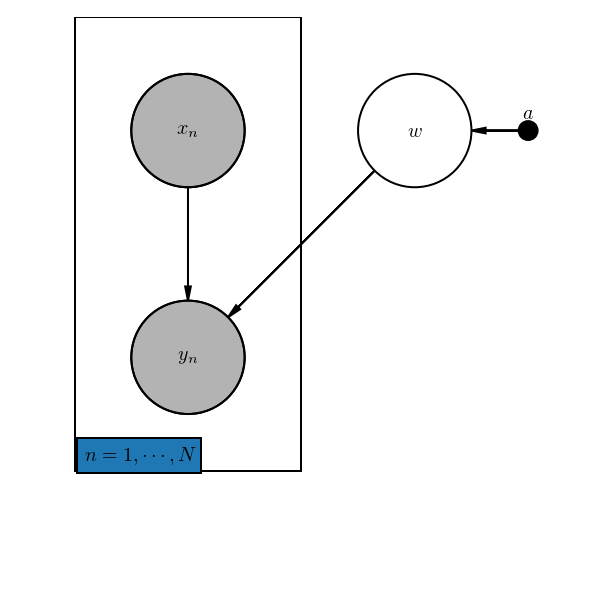

In [86]:
pgm = daft.PGM((5,5),node_unit=2)
pgm.add_node(daft.Node('x',r'$x_n$',1.5,4,observed=True))
pgm.add_node(daft.Node('y',r'$y_n$',1.5,2,observed=True))
pgm.add_node(daft.Node('w',r'$w$',3.5,4))
pgm.add_node(daft.Node('a',r'$a$',4.5,4,fixed=True))
pgm.add_edge('x','y')
pgm.add_edge('w','y')
pgm.add_edge('a','w')
pgm.add_plate(daft.Plate([.5, 1, 2, 4], label=r"$n = 1, \cdots, N$"))
pgm.render()

1-dimensional linear regression

In [180]:
d = 1
N = 100
sigmoid = torch.sigmoid
w0 = torch.tensor([3.5])
b0 = torch.tensor(4)
x = torch.linspace(-3,3,N) #(torch.linspace(-3,3,N)+0.5*torch.randn(N)).reshape(1,-1)
#x = torch.cat(3*(pts,)).t()
#print(x.shape,w.shape)
y = w0*x + b0*torch.ones(N)+ torch.randn(N) # y=wx+b+eps

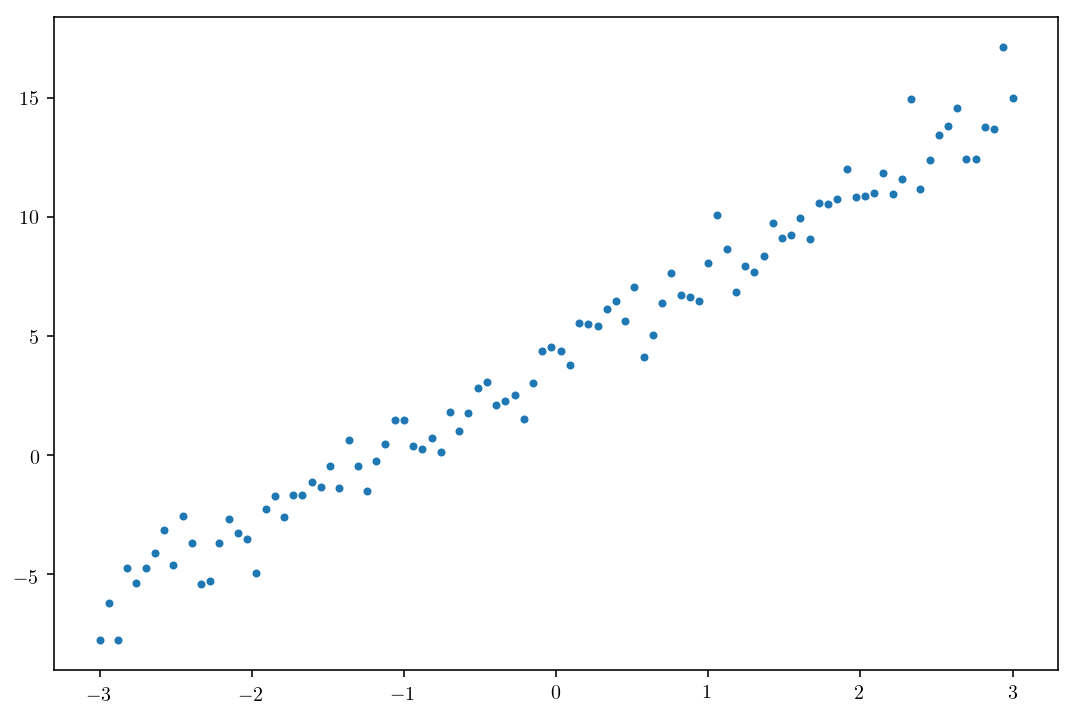

In [181]:
plt.plot(x.numpy(),y.numpy(),'.')
plt.show()

In [189]:
def model(X,Y):
    w = pyro.sample('w',dist.Normal(0,1))
    b = pyro.sample('b',dist.Normal(0,1))
    with pyro.plate('data',len(X)):
        y = pyro.sample('y',dist.Normal(w*X+b,1),obs=Y)

def guide(X,Y):
    w_loc = pyro.param('w_loc',torch.tensor(0.))
    w_scale = pyro.param('w_scale',torch.ones(d),constraint=constraints.positive)
    b_loc = pyro.param('b_loc',torch.tensor(0.))
    b_scale = pyro.param('b_scale',torch.ones(d),constraint=constraints.positive)
    w = pyro.sample('w',dist.Normal(w_loc,w_scale))
    b = pyro.sample('b',dist.Normal(b_loc,b_scale))

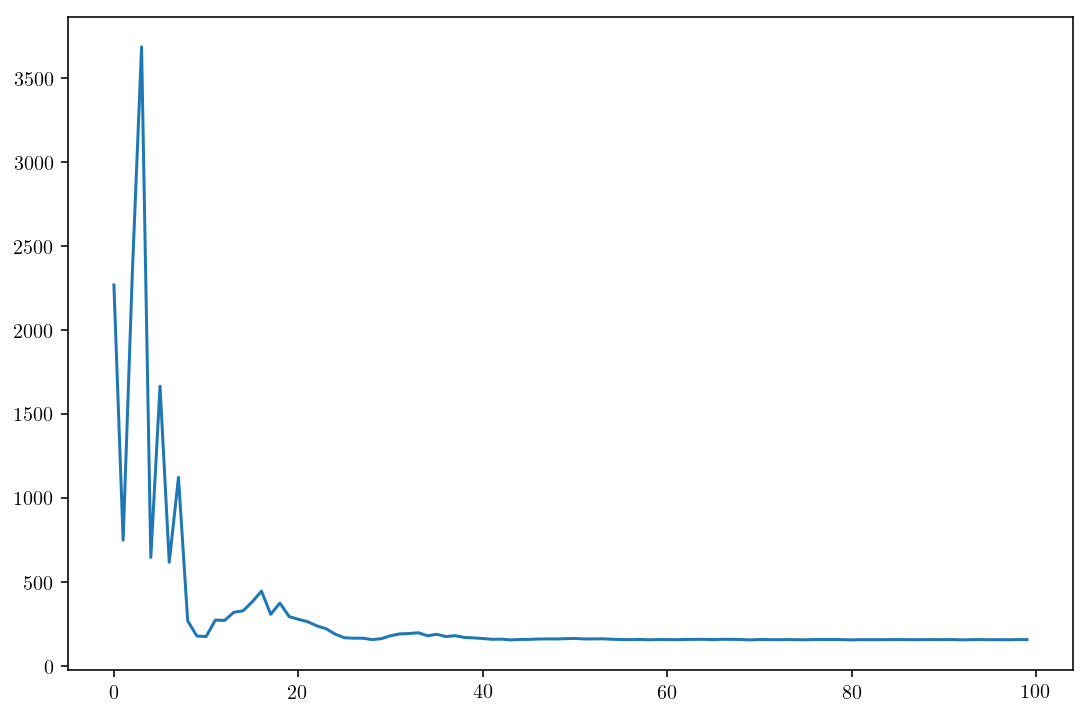

In [190]:
opt = Adam({'lr':0.5})
svi = SVI(model, guide, optim=opt, loss=Trace_ELBO(), num_samples=50)
pyro.clear_param_store()
n_steps = 100
losses = []
for i in range(n_steps):
    losses.append(svi.step(x,y))
plt.plot(losses)
plt.show()

In [191]:
w_fit = pyro.param('w_loc').detach().item()
b_fit = pyro.param('b_loc').detach().item()

In [192]:
print("true w: {}".format(w0))
print("map fit w: {}".format(w_fit))
print("true b: {}".format(4))
print("map fit b: {}".format(b_fit))

true w: tensor([3.5000])
map fit w: 3.5207643508911133
true b: 4
map fit b: 4.060047149658203


2D linear regression

In [209]:
d = 2
n1 = 50
N=n1**2
x1, y1 = torch.linspace(-1,1,n1), torch.linspace(-1,1,n1)
X,Y = torch.meshgrid(x1,y1)
X = X.flatten()
Y = Y.flatten()
data_x = torch.stack((X,Y)).t()
w0 = torch.tensor([2.5,-1.3])
b0 = torch.tensor([0.8])
Z = data_x.mm(w0.unsqueeze(-1)).squeeze() + b0*torch.ones_like(X)+ torch.randn(X.shape)

In [210]:
pyro.enable_validation(True)

In [229]:
def model(x,y):
    w = pyro.sample('w',dist.MultivariateNormal(torch.zeros(d),covariance_matrix=torch.eye(d)))
    b = pyro.sample('b',dist.Normal(torch.zeros(1),1))
    loc = x.mm(w.unsqueeze(-1)).squeeze() + b*torch.ones(x.shape[0])
    with pyro.plate('data',len(x)):
        z = pyro.sample('y',dist.Normal(loc,1),obs=y)

def guide(x,y):
    w_loc = pyro.param('w_loc',torch.zeros(d))
    w_scale_tril = pyro.param("w_scale_tril",torch.eye(d),constraint=constraints.lower_cholesky)
    b_loc = pyro.param('b_loc',torch.tensor(0.))
    b_scale = pyro.param('b_scale',torch.ones(1),constraint=constraints.positive)
    w = pyro.sample('w',dist.MultivariateNormal(w_loc,scale_tril=w_scale_tril))
    b = pyro.sample('b',dist.Normal(b_loc,b_scale))

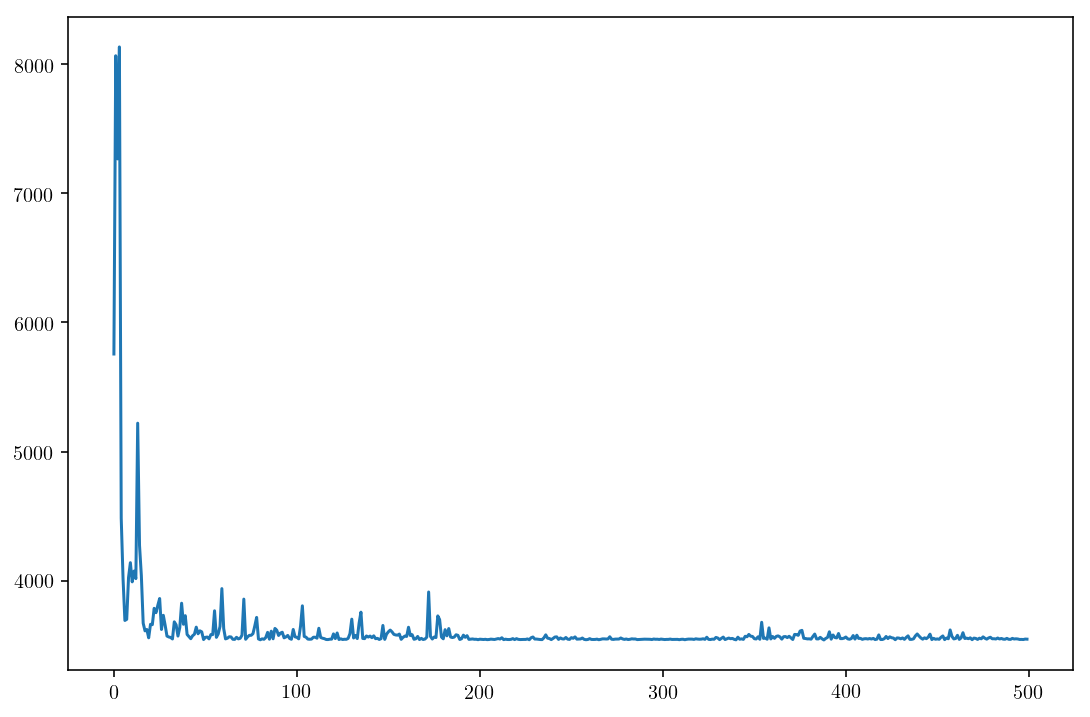

In [230]:
opt = Adam({'lr':0.5})
svi = SVI(model, guide, optim=opt, loss=Trace_ELBO(), num_samples=200)
pyro.clear_param_store()
n_steps = 500
losses = []
for i in range(n_steps):
    losses.append(svi.step(data_x,Z))
plt.plot(losses)
plt.show()

In [235]:
w_fit = pyro.param('w_loc').detach()
w_tril_fit = pyro.param('w_scale_tril').detach()
b_fit = pyro.param('b_loc').detach().numpy()

In [236]:
w_dist = dist.MultivariateNormal(w_fit, scale_tril=w_tril_fit)

In [253]:
xx = torch.linspace(-10,10,100)
Xp,Yp = torch.meshgrid(xx,xx)
pts = torch.stack((Xp,Yp)).reshape(2,10000).t()

In [259]:
p_plot = w_dist.log_prob(pts).reshape(100,100)

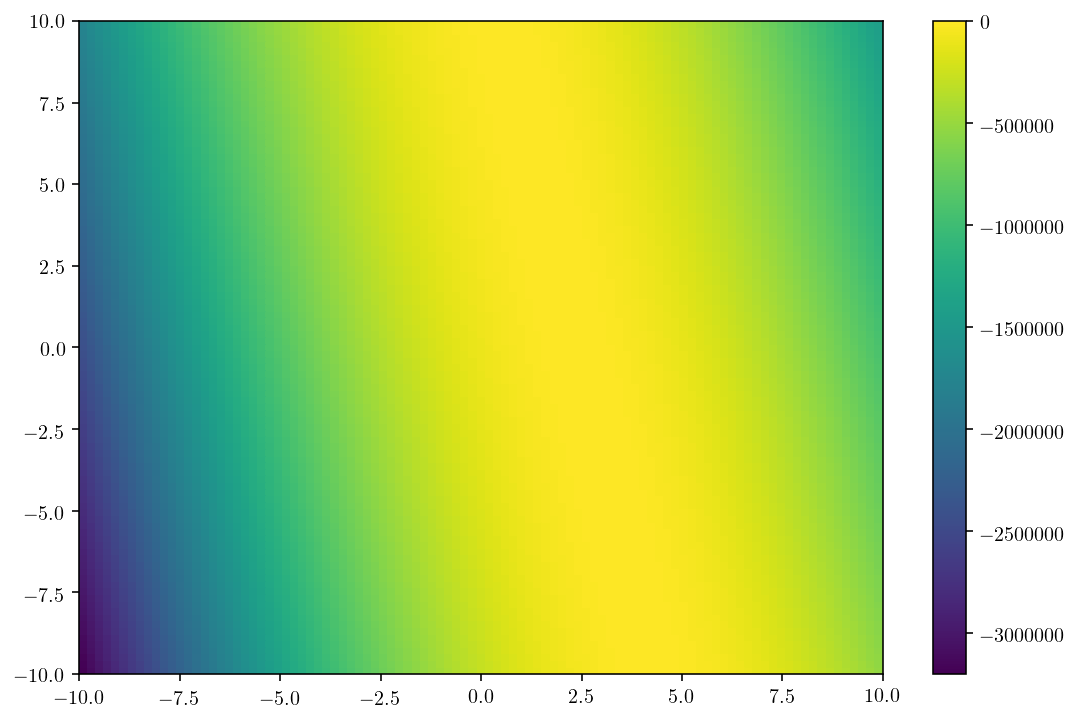

In [260]:
plt.pcolormesh(Xp.numpy(),Yp.numpy(),p_plot.numpy())
plt.colorbar()
plt.show()

In [232]:
print("true w: {}".format(w0))
print("map fit w: {}".format(w_fit))
print("true b: {}".format(b0))
print("map fit b: {}".format(b_fit))

true w: tensor([ 2.5000, -1.3000])
map fit w: [ 2.488978  -1.2865477]
true b: tensor([0.8000])
map fit b: 0.8228010535240173


In [61]:
print("ground truth weights: {}".format(w.squeeze()))
print("variational mean: {}".format(mean))
print("variational std. dev: {}".format(scale))

ground truth weights: tensor([0., 1., 2.])
variational mean: [-0.0024607  -0.00247834 -0.00247811]
variational std. dev: [0.04759608 0.04617324 0.05206733]


In [173]:
d = dist.Normal(torch.zeros(2),1)

In [174]:
d.sample().shape

torch.Size([2])